In [1]:
!pip install requests beautifulsoup4 nltk wordcloud matplotlib pandas textblob scikit-learn imbalanced-learn joblib


In [2]:
import requests
from bs4 import BeautifulSoup
import re
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from collections import Counter
import numpy as np
import joblib

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
url = "https://en.wikipedia.org/wiki/United_Kingdom"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Extract all paragraph text
text = ' '.join([p.text for p in soup.find_all('p')])
print("Raw Text Sample:\n", text[:500])


Raw Text Sample:
 
 The United Kingdom of Great Britain and Northern Ireland, commonly known as the United Kingdom (UK) or Britain,[m] is a country in Northwestern Europe, off the coast of the continental mainland. It comprises England, Scotland, Wales, and Northern Ireland.[n] The UK includes the island of Great Britain, the north-eastern part of the island of Ireland, and most of the smaller islands within the British Isles, covering 94,354 square miles (244,376 km2).[f] Northern Ireland shares a land border wi


In [4]:
text = re.sub(r'\[.*?\]', '', text)
text = re.sub(r'[^a-zA-Z. ]', '', text)
text = text.lower()


In [6]:
import nltk

# Download the 'punkt_tab' data
nltk.download('punkt_tab')

# Now try to tokenize
sentences = sent_tokenize(text)
print("Sample Sentences:", sentences[:5])

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Sample Sentences: [' the united kingdom of great britain and northern ireland commonly known as the united kingdom uk or britain is a country in northwestern europe off the coast of the continental mainland.', 'it comprises england scotland wales and northern ireland.', 'the uk includes the island of great britain the northeastern part of the island of ireland and most of the smaller islands within the british isles covering  square miles km.', 'northern ireland shares a land border with the republic of ireland otherwise the united kingdom is surrounded by the atlantic ocean the north sea the english channel the celtic sea and the irish sea.', 'the uk maintains sovereignty over the british overseas territories which are located across various oceans and seas globally.']


In [7]:
def analyze_sentiment(sentence):
    polarity = TextBlob(sentence).sentiment.polarity
    if polarity > 0:
        return "positive"
    elif polarity < 0:
        return "negative"
    else:
        return "neutral"

sentiments = [analyze_sentiment(s) for s in sentences]
df = pd.DataFrame({'sentence': sentences, 'sentiment': sentiments})
print(df.head())


                                            sentence sentiment
0   the united kingdom of great britain and north...  positive
1  it comprises england scotland wales and northe...   neutral
2  the uk includes the island of great britain th...  positive
3  northern ireland shares a land border with the...   neutral
4  the uk maintains sovereignty over the british ...   neutral


In [8]:
words = word_tokenize(text)
stop_words = set(stopwords.words("english"))
filtered_words = [word for word in words if word not in stop_words and word.isalpha()]
print("Filtered Words Sample:", filtered_words[:20])


Filtered Words Sample: ['united', 'kingdom', 'great', 'britain', 'northern', 'ireland', 'commonly', 'known', 'united', 'kingdom', 'uk', 'britain', 'country', 'northwestern', 'europe', 'coast', 'continental', 'mainland', 'comprises', 'england']


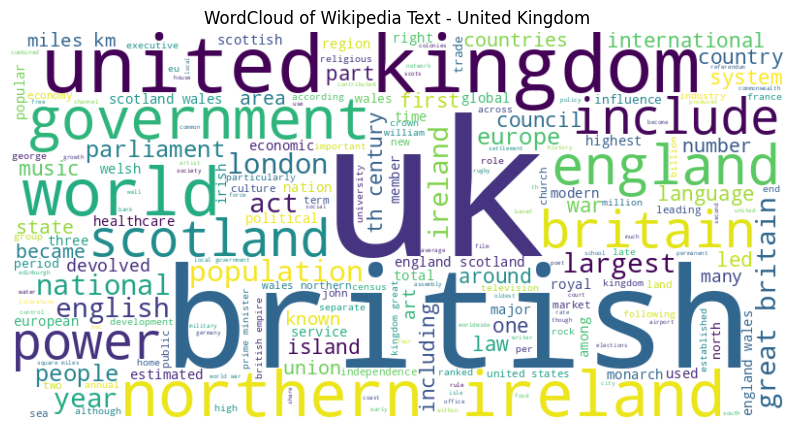

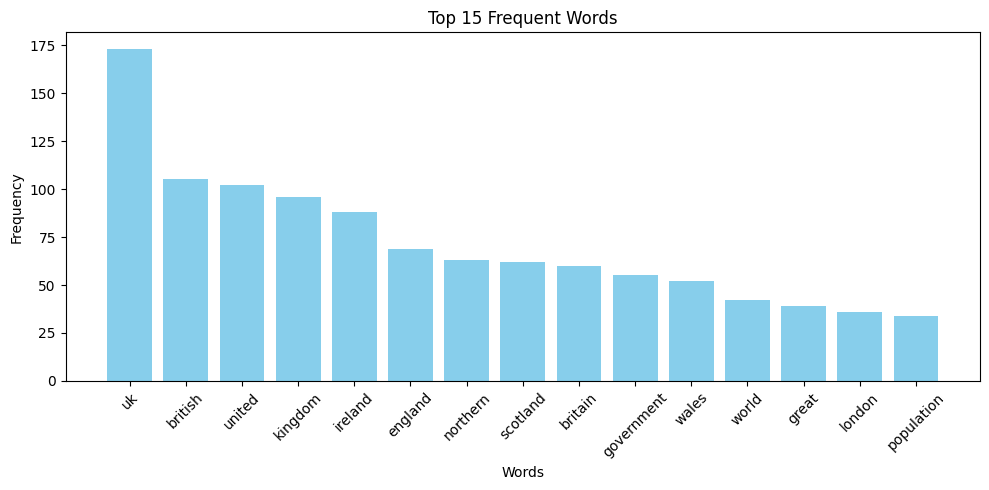

In [9]:
all_words = ' '.join(filtered_words)

# WordCloud
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Wikipedia Text - United Kingdom")
plt.show()

# Top 15 Words Bar Plot
word_freq = Counter(filtered_words)
most_common_words = word_freq.most_common(15)

words, freqs = zip(*most_common_words)
plt.figure(figsize=(10, 5))
plt.bar(words, freqs, color='skyblue')
plt.title("Top 15 Frequent Words")
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [10]:
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(df['sentence'])
print("TF-IDF Matrix Shape:", X.shape)


TF-IDF Matrix Shape: (677, 3159)


In [11]:
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df_binary = df.dropna(subset=['label'])
X_binary = X[df_binary.index]
y_binary = df_binary['label'].astype(int)

print("Binary Data Shape:", X_binary.shape, y_binary.shape)


Binary Data Shape: (384, 3159) (384,)


In [12]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_binary, y_binary)

print("After SMOTE:", X_resampled.shape, y_resampled.shape)


After SMOTE: (594, 3159) (594,)


In [13]:
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_resampled, y_resampled)
print("📊 Logistic Regression:\n", classification_report(y_resampled, logreg_model.predict(X_resampled)))


📊 Logistic Regression:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       297
           1       0.99      1.00      1.00       297

    accuracy                           1.00       594
   macro avg       1.00      1.00      1.00       594
weighted avg       1.00      1.00      1.00       594



In [14]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_resampled, y_resampled)
print("🌳 Decision Tree:\n", classification_report(y_resampled, dt_model.predict(X_resampled)))


🌳 Decision Tree:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       297
           1       1.00      1.00      1.00       297

    accuracy                           1.00       594
   macro avg       1.00      1.00      1.00       594
weighted avg       1.00      1.00      1.00       594



In [15]:
rf_model = RandomForestClassifier()
rf_model.fit(X_resampled, y_resampled)
print("🌲 Random Forest:\n", classification_report(y_resampled, rf_model.predict(X_resampled)))


🌲 Random Forest:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       297
           1       1.00      1.00      1.00       297

    accuracy                           1.00       594
   macro avg       1.00      1.00      1.00       594
weighted avg       1.00      1.00      1.00       594



In [16]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_resampled, y_resampled)
print("🚀 Gradient Boosting:\n", classification_report(y_resampled, gb_model.predict(X_resampled)))


🚀 Gradient Boosting:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98       297
           1       0.97      1.00      0.98       297

    accuracy                           0.98       594
   macro avg       0.98      0.98      0.98       594
weighted avg       0.98      0.98      0.98       594



In [17]:
nb_model = MultinomialNB()
nb_model.fit(X_resampled, y_resampled)
print("🧠 Naive Bayes:\n", classification_report(y_resampled, nb_model.predict(X_resampled)))


🧠 Naive Bayes:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       297
           1       1.00      0.98      0.99       297

    accuracy                           0.99       594
   macro avg       0.99      0.99      0.99       594
weighted avg       0.99      0.99      0.99       594



In [18]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_resampled.toarray(), y_resampled)
print("👥 KNN:\n", classification_report(y_resampled, knn_model.predict(X_resampled.toarray())))


👥 KNN:
               precision    recall  f1-score   support

           0       0.52      1.00      0.69       297
           1       1.00      0.08      0.15       297

    accuracy                           0.54       594
   macro avg       0.76      0.54      0.42       594
weighted avg       0.76      0.54      0.42       594



In [19]:
joblib.dump(rf_model, 'uk_random_forest_sentiment_model.pkl')
joblib.dump(tfidf_vectorizer, 'uk_tfidf_vectorizer.pkl')


['uk_tfidf_vectorizer.pkl']